# Self-supervised contrastive learning with SimSiam

This notebook shows how to use Self-supervised non-contrastive learning with SimSiam and RandAugment as data augmentation. This notebook makes use of the given bounding boxes from WENN as well as the same bounding boxes on the images taken before and after the image. The image extraction can be done with the cut_out_and_reparse_for_selfsupervised.ipynb in notebooks/preprocessing/other folder.

## Setup and loading car images

Import packages

In [1]:
import sys
from preprocessing.rand_augmenter import RandAugmenter

import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns

import copy
import os
import pathlib
from pathlib import Path
import json

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import mlflow
import resnet_cifar
from sklearn.neighbors import KNeighborsClassifier
from genericpath import isdir
from sklearn.manifold import TSNE
from simple_siamese import get_encoder, get_predictor, SimSiam, train_test_split_array


2022-08-25 14:43:25.423729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 14:43:25.423847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



### Set up RandAugment Parameter

One can add more transformations here, however the results are very good when only using Rotate, Color and TranslateX+Y

In [2]:
op_list = [
    #'AutoContrast', # problematic for 4D Tensors,but runs fine for single images [224 224 3]
    #'Equalize', # problematic for 4D Tensors,but runs fine for single images [224 224 3]
    #'Invert',
    'Rotate',
    #'Posterize',
    #'Solarize',
    #'SolarizeAdd',
    'Color',
    #'Contrast',
    #'Brightness',
    #'Sharpness',  # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset [32 224 224 3]
    #'ShearX', # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset[32 224 224 3]
    #'ShearY', # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset[32 224 224 3]
    'TranslateX',
    'TranslateY',
    #'Cutout' # doesn't work with 4D Tensors yet! -> do not use for tf.Data.Dataset[32 224 224 3]
]
N = 2
M = 9


In [3]:
# Enable auto-logging to MLflow to capture TensorBoard and Keras metrics.
mlflow.tensorflow.autolog()
mlflow.keras.autolog()

2022/08/25 14:43:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


In [4]:
#Setup Mlflow Tracking for Backbone (SimSiam) and FinalClassifier (KNN) based on features extracted from Backbone
EXPERIMENT1 = "Backbone"
existing_backbone_ID = mlflow.get_experiment_by_name(EXPERIMENT1)
if not existing_backbone_ID:
    EXPERIMENT_ID_Backbone = mlflow.create_experiment(EXPERIMENT1)
EXP1 = mlflow.set_experiment(EXPERIMENT1)

EXPERIMENT2 = "FinalClassifier"
existing_final_ID = mlflow.get_experiment_by_name(EXPERIMENT2)
if not existing_final_ID:
    EXPERIMENT_ID_Final = mlflow.create_experiment(EXPERIMENT2)
EXP2 = mlflow.set_experiment(EXPERIMENT2)

In [5]:
#Define Hyperparameters
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 20
CROP_TO = 80
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 4
WEIGHT_DECAY = 0.0005

In [6]:
#Loading images that are labelled that will be used for the final classifier
with Path(r"../../preprocessing/other/restructured.json").open() as f:
    data = json.load(f)

annotations = data['annotations']

image_label_dict = {}
for annotate in annotations:
    image_label_dict[annotate['id']] = annotate['category_id']

#print(image_label_dict)


In [7]:
#inspect data folder
#loading labeled images and zeropadding
data_dir = r"../../../data/cropped/"
data_dir = pathlib.Path(data_dir)
images = []
images_complete = []
labels = []
for file in data_dir.glob('*.png'):
    image_id = int(str(file).split('/')[-1].split('.')[0])
    if image_id in image_label_dict:
        im = cv2.imread(str(file))
        (height, width,_) = (im.shape)
        if height < width:
            diff = width - height
            im = cv2.copyMakeBorder(im, top=int(diff / 2), bottom=int(diff / 2), left=0, right=0, borderType=cv2.BORDER_CONSTANT,value=[0,0,0])
        elif width < height:
            diff = height-width
            im = cv2.copyMakeBorder(im,
                                    top=0,
                                    bottom=0,
                                    right=int(diff / 2),
                                    left = int(diff / 2),
                                    borderType=cv2.BORDER_CONSTANT,
                                    value=[0, 0, 0])
        im = cv2.resize(im, (CROP_TO, CROP_TO))
        images.append(im)
        images_complete.append(im)
        labels.append(image_label_dict[image_id])
        #print(image_label_dict[image_id])
images = np.stack(images, axis=0)
labels = np.stack(labels, axis=0)
print(images.shape)
print(labels.shape)

(897, 80, 80, 3)
(897,)


In [8]:
#loading additional unlabeled images and zeropadding
data_dir_allImg = r"../../../data/cropped_additional"
data_dir_folder = pathlib.Path(data_dir_allImg)
for file in data_dir_folder.glob('*.png'):
    im = cv2.imread(str(file))
    (height, width,_) = (im.shape)
    if height < width:
        diff = width - height
        im = cv2.copyMakeBorder(im, top=int(diff / 2), bottom=int(diff / 2), left=0, right=0, borderType=cv2.BORDER_CONSTANT,value=[0,0,0])
    elif width < height:
        diff = height-width
        im = cv2.copyMakeBorder(im,
                                top=0,
                                bottom=0,
                                right=int(diff / 2),
                                left = int(diff / 2),
                                borderType=cv2.BORDER_CONSTANT,
                                value=[0, 0, 0])
    im = cv2.resize(im, (CROP_TO, CROP_TO))
    images_complete.append(im)
images_complete = np.stack(images_complete, axis=0)
print(images.shape)
print(labels.shape)
print(images_complete.shape)


(897, 80, 80, 3)
(897,)
(2691, 80, 80, 3)


## Setting up the data augmentation pipeline 
Using RandAugment for DataAugmentation and converting the data into TensorFlow Dataset objects

['Rotate', 'Color', 'TranslateX', 'TranslateY']
2 layers with magnitude 9, with a total of 4 operations.


2022-08-25 14:43:39.363112: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-25 14:43:39.363268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-25 14:43:40.359140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


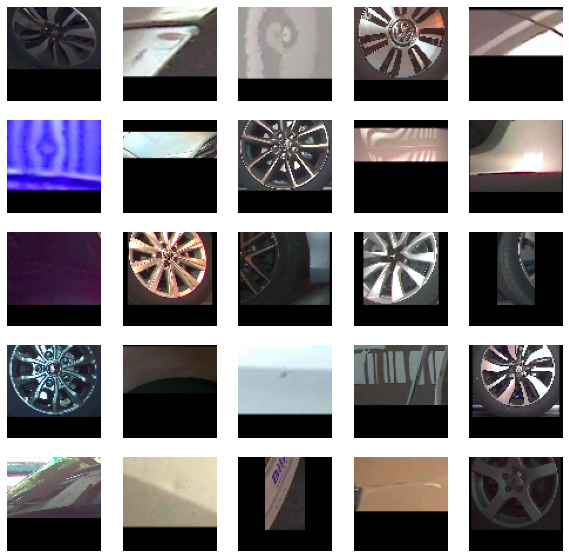

--------


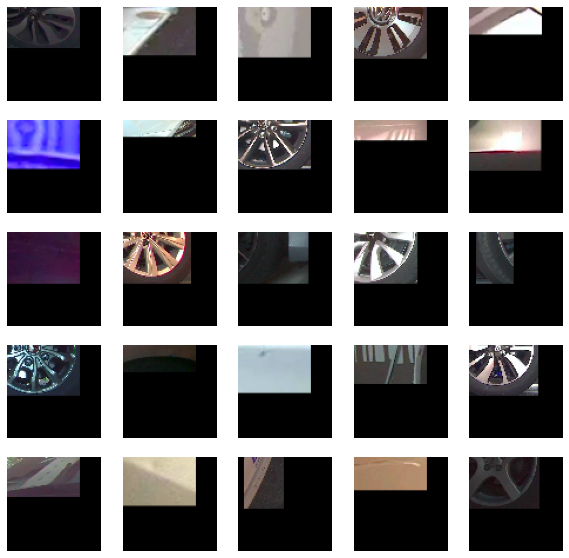

In [9]:
#setting up RandAugment
test_aug = RandAugmenter(N, M, op_list)
test_aug.set_operations(op_list)
test_aug.summary()

#dataset 1
images_complete = test_aug.randaugment_transform(images_complete)
ssl_ds_one = tf.data.Dataset.from_tensor_slices(images_complete)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#dataset 2
images_complete = test_aug.randaugment_transform(images_complete)
ssl_ds_two = tf.data.Dataset.from_tensor_slices(images_complete)
ssl_ds_two = (ssl_ds_two.shuffle(1024, seed=SEED).batch(BATCH_SIZE).prefetch(AUTO))
print(type(ssl_ds_two))

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
print(type(sample_images_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

print('--------')

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

2022/08/25 14:43:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


Epoch 1/20


2022-08-25 14:43:46.788452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 75s 2s/step - loss: -0.9055
Epoch 2/20
43/43 [==============================] - 73s 2s/step - loss: -0.9626
Epoch 3/20
43/43 [==============================] - 75s 2s/step - loss: -0.9640
Epoch 4/20
43/43 [==============================] - 64s 1s/step - loss: -0.9641
Epoch 5/20
43/43 [==============================] - 62s 1s/step - loss: -0.9625
Epoch 6/20
43/43 [==============================] - 61s 1s/step - loss: -0.9612
Epoch 7/20
43/43 [==============================] - 59s 1s/step - loss: -0.9628
Epoch 8/20
43/43 [==============================] - 61s 1s/step - loss: -0.9626
Epoch 9/20
43/43 [==============================] - 76s 2s/step - loss: -0.9628


2022/08/25 14:53:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Model <simple_siamese.SimSiam object at 0x2bedc4820> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.


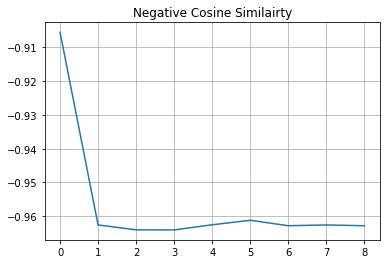

In [10]:
#final run with best optuna optimiser (values need to be set from above)
run_name = str(BATCH_SIZE) + '_' + str(EPOCHS) + '_' + str(CROP_TO) + '_' + str(SEED) + '_' + str(
    PROJECT_DIM) + '_' + str(LATENT_DIM) + '_' + str(WEIGHT_DECAY)
with mlflow.start_run(experiment_id=EXP1.experiment_id) as run1:
    BACKBONE_ID = run1.info.run_id
    mlflow.log_metric('batch_size', BATCH_SIZE)
    mlflow.log_metric('PROJECT_DIM', PROJECT_DIM)
    mlflow.log_param('CROP_TO', CROP_TO)
    mlflow.log_param('SEED', SEED)
    mlflow.log_param('LATENT_DIM', LATENT_DIM)
    mlflow.log_param('WEIGHT_DECAY', WEIGHT_DECAY)
    mlflow.log_param('op_list', op_list)
    mlflow.log_param('mode', 'additional cropped - RandAugment')
    # Create a cosine decay learning scheduler.
    num_training_samples = len(images_complete)
    steps = EPOCHS * (num_training_samples // BATCH_SIZE)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.03,
                                                              decay_steps=steps)

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                      patience=5,
                                                      restore_best_weights=True)

    # Compile model and start training.
    simsiam = SimSiam(get_encoder(), get_predictor())
    simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
    history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [11]:
#Trained SimSiam
from sklearn.metrics import recall_score, precision_score, confusion_matrix
n_neighbors = [2, 3, 4, 5]
TRAIN_TEST_SPLIT = [0.1, 0.5, 0.9]

for n in n_neighbors:
    for t in TRAIN_TEST_SPLIT:
        with mlflow.start_run(experiment_id=EXP2.experiment_id):
            train_images, test_images, train_labels, test_labels = train_test_split_array(
                images, labels, t)
            backbone = tf.keras.Model(simsiam.encoder.input,
                                      simsiam.encoder.get_layer("backbone_pool").output)
            train_backbone = backbone(train_images)
            #print(train_backbone.shape)
            test_backbone = backbone(test_images)
            #print(test_backbone.shape)
            mlflow.log_param('BACKBONE_ID', BACKBONE_ID)
            mlflow.log_param('TRAIN_TEST_SPLIT', t)
            mlflow.log_param('n_neighbors', n)
            mlflow.log_param('mode', 'additional cropped - RandAugment')
            neigh = KNeighborsClassifier(n_neighbors=n)
            neigh.fit(train_backbone, train_labels)
            test_acc = neigh.score(test_backbone, test_labels)
            predict_labels = neigh.predict(test_backbone)
            confusion_matrix_result = confusion_matrix(test_labels, predict_labels)
            mlflow.log_param('confusion_matrix', confusion_matrix_result)
            recall_micro = recall_score(test_labels, predict_labels, average = 'micro')
            mlflow.log_param('recall_micro', recall_micro)
            recall_macro = recall_score(test_labels, predict_labels, average='macro')
            mlflow.log_param('recall_macro', recall_macro)
            precision = precision_score(test_labels, predict_labels, average='micro')
            mlflow.log_param('precision', precision)
            #print("neighbours: {}".format(n))
            #print("TRAIN_TEST_SPLIT: {}".format(t))
            print("Test accuracy: {:.2f}".format(test_acc * 100))
            mlflow.log_param('test_acc', test_acc)


Test accuracy: 43.81
Test accuracy: 47.66
Test accuracy: 45.56
Test accuracy: 48.89
Test accuracy: 50.56
Test accuracy: 56.67
Test accuracy: 48.51
Test accuracy: 50.78
Test accuracy: 60.00
Test accuracy: 48.27
Test accuracy: 50.78
Test accuracy: 58.89


/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/melinasoysal/miniforge3/envs/tensorflow-vscode/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(<AxesSubplot:xlabel='tsne-1', ylabel='tsne-2'>,)

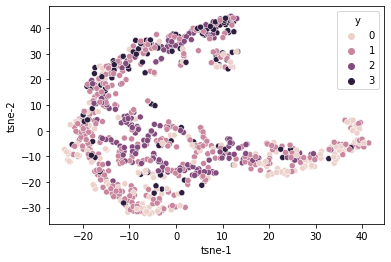

In [12]:
#plot t-Distributed Stochastic Neighbour Embedding
representation = TSNE().fit_transform(train_backbone)
df_tsne = pd.DataFrame({"y": train_labels, "tsne-1": representation[:,0], "tsne-2": representation[:,1]})
sns.scatterplot(data=df_tsne, hue="y", x="tsne-1", y="tsne-2"),


In [14]:
#only ResNet Backbone, no SimSiam to compare results with and without finetuning to WENN Dataset
N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1
import resnet_cifar
n_neighbors = [2, 3, 4, 5]
TRAIN_TEST_SPLIT = [0.1, 0.5, 0.9]

for n in n_neighbors:
    for t in TRAIN_TEST_SPLIT:
        with mlflow.start_run(experiment_id=EXP2.experiment_id):
            train_images, test_images, train_labels, test_labels = train_test_split_array(
                images, labels, t)

            x_train = resnet_cifar.stem(train_images.astype(np.float32) / 255.)
            x_train = resnet_cifar.learner(x_train, NUM_BLOCKS)
            x_train = tf.keras.layers.Flatten()(x_train)

            x_test = resnet_cifar.stem(test_images.astype(np.float32) /255.)
            x_test = resnet_cifar.learner(x_test, NUM_BLOCKS)
            x_test = tf.keras.layers.Flatten()(x_test)


            mlflow.log_param('BACKBONE_ID', 'onlyResNet')
            mlflow.log_param('TRAIN_TEST_SPLIT', t)
            mlflow.log_param('n_neighbors', n)
            mlflow.log_param('mode', 'additional cropped - RandAugment')
            neigh = KNeighborsClassifier(n_neighbors=n)
            neigh.fit(x_train.numpy(), train_labels)
            test_acc = neigh.score(x_test.numpy(), test_labels)
            #print("neighbours: {}".format(n))
            #print("TRAIN_TEST_SPLIT: {}".format(t))
            print("Test accuracy: {:.2f}%".format(test_acc * 100))
            mlflow.log_param('test_acc', test_acc)
            predict_labels = neigh.predict(x_test.numpy())
            confusion_matrix_result = confusion_matrix(test_labels, predict_labels)
            mlflow.log_param('confusion_matrix', confusion_matrix_result)
            recall_micro = recall_score(test_labels, predict_labels, average='micro')
            mlflow.log_param('recall_micro', recall_micro)
            recall_macro = recall_score(test_labels, predict_labels, average='macro')
            mlflow.log_param('recall_macro', recall_macro)
            precision = precision_score(test_labels, predict_labels, average='micro')
            mlflow.log_param('precision', precision)


Test accuracy: 41.96%
Test accuracy: 38.53%
Test accuracy: 33.33%
Test accuracy: 41.46%
Test accuracy: 38.75%
Test accuracy: 33.33%
Test accuracy: 41.71%
Test accuracy: 40.76%
Test accuracy: 31.11%
Test accuracy: 39.60%
Test accuracy: 41.20%
Test accuracy: 34.44%
